# 1- Data Prep

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('data/ai_posts.csv')

# define a function to convert the string format to a list
def convert_tags(tag_string):
    if isinstance(tag_string, str):
        tag_list = tag_string.strip('<>').split('><')
    else:
        tag_list = []
    return tag_list

# apply the function to the 'tags' column of the dataframe
df['tags'] = df['tags'].apply(convert_tags)

# 2- Labeled Data - Analysis:
Some preliminary analysis of our train-data help us understand where we lack even minimum amount of data to train a simple classifier. E.g., there are so many tags that we have only one posts. Capturing these tags, we can decide on whether:
- We do not need to include them in the classification model
- They are mis-labeled or they are duplication of already pre-existing labels. 
- They are valid labels that we need them to be in our classifier, but we do not have enough posts on them, yet. Synthetic generation of train-samples could help us with these types of conditions.


## 2-1- Frequencies

In [14]:
# Create a list of all the tags
all_tags = [tag for tags in df['tags'] for tag in tags]

# Create a dictionary to store the frequency of each tag
tag_freq = {}
for tag in all_tags:
    if tag in tag_freq:
        tag_freq[tag] += 1
    else:
        tag_freq[tag] = 1

# Sort the dictionary by values
sorted_tag_freq = dict(sorted(tag_freq.items(), key=lambda x: x[1], reverse=True))

# Print the sorted dictionary
print(sorted_tag_freq)

{'neural-networks': 2398, 'reinforcement-learning': 2258, 'machine-learning': 2157, 'deep-learning': 1836, 'convolutional-neural-networks': 1090, 'natural-language-processing': 672, 'computer-vision': 472, 'deep-rl': 468, 'reference-request': 467, 'classification': 445, 'comparison': 439, 'training': 423, 'terminology': 383, 'q-learning': 365, 'recurrent-neural-networks': 342, 'tensorflow': 337, 'python': 333, 'papers': 322, 'dqn': 318, 'image-recognition': 284, 'long-short-term-memory': 274, 'ai-design': 266, 'datasets': 257, 'objective-functions': 255, 'keras': 248, 'game-ai': 239, 'backpropagation': 238, 'generative-adversarial-networks': 237, 'math': 234, 'object-detection': 219, 'transformer': 217, 'optimization': 204, 'definitions': 202, 'gradient-descent': 189, 'pytorch': 189, 'markov-decision-process': 187, 'policy-gradients': 185, 'applications': 184, 'philosophy': 180, 'agi': 180, 'deep-neural-networks': 175, 'genetic-algorithms': 175, 'data-preprocessing': 157, 'activation-f

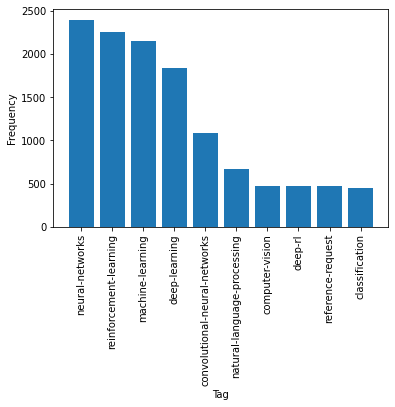

In [15]:
slice_size=10
# Plot the top most frequent tags
top4plot = dict(list(sorted_tag_freq.items())[:slice_size])

# Create a bar plot of the tag frequency
plt.bar(top4plot.keys(), top4plot.values())
plt.xticks(rotation=90)
plt.xlabel('Tag')
plt.ylabel('Frequency')
plt.show()

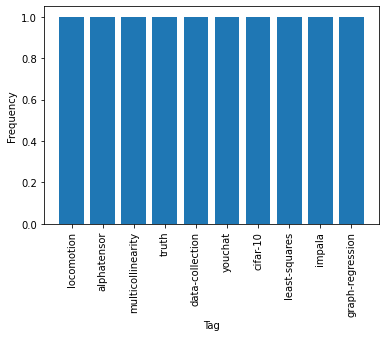

In [16]:
# Plot the least frequent tags
tail4plot = dict(list(sorted_tag_freq.items())[-slice_size:])

# Create a bar plot of the tag frequency
plt.bar(tail4plot.keys(), tail4plot.values())
plt.xticks(rotation=90)
plt.xlabel('Tag')
plt.ylabel('Frequency')
plt.show()

## 2-2- Co-occurrence

In [17]:
len(sorted_tag_freq)

981

Due to the large size, we create the graph on a subset:

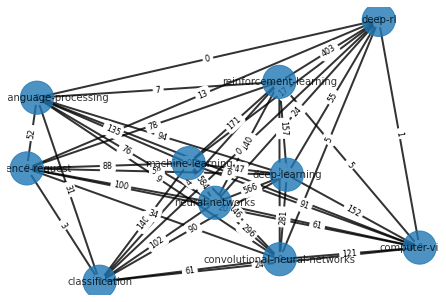

In [18]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a list of unique tags
# unique_tags = list(set(all_tags))
unique_tags = top4plot

# Create an empty co-occurrence matrix
co_matrix = pd.DataFrame(0, index=unique_tags, columns=unique_tags)

# Fill the co-occurrence matrix
for tags in df['tags']:
    for i in range(len(tags)):
        if not tags[i] in unique_tags:
            continue
        for j in range(i+1, len(tags)):
            if not tags[j] in unique_tags:
                continue
            co_matrix.loc[tags[i], tags[j]] += 1
            co_matrix.loc[tags[j], tags[i]] += 1

# Convert the co-occurrence matrix to an edge list
edge_list = co_matrix.stack().reset_index()
edge_list.columns = ['source', 'target', 'weight']

# Create a graph from the edge list
G = nx.from_pandas_edgelist(edge_list, edge_attr='weight')

# Set node size based on the degree of each node
node_size = [G.degree(node) * 100 for node in G.nodes()]

# Draw the graph
pos = nx.spring_layout(G, k=0.5, iterations=50)
nx.draw(G, pos, with_labels=True, node_size=node_size, font_size=10, alpha=0.8, width=2)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.show()

Graph on predicted-tags (as cleaned-up graph); how it is different on the cleaned up and original one.

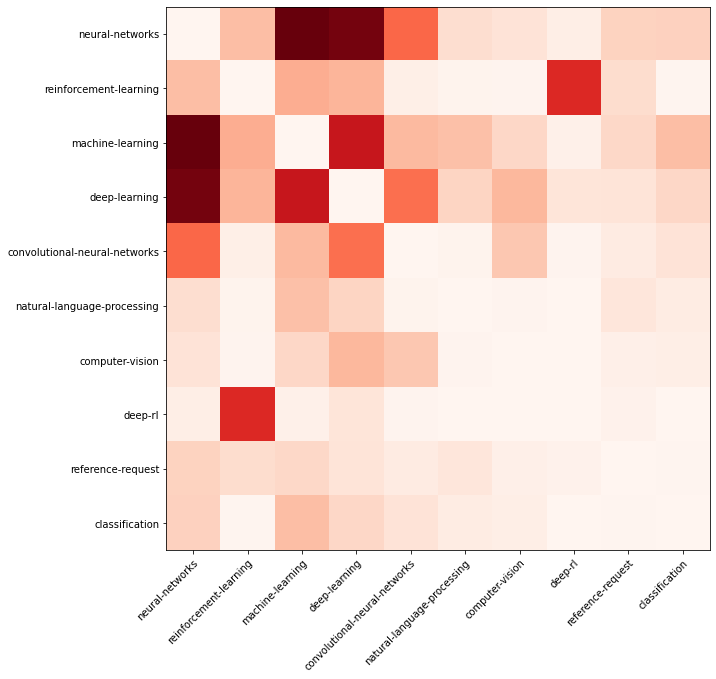

In [19]:
# Create a co-occurrence matrix
co_occurrence = co_matrix.copy()
            
# Set the diagonal elements to zero
np.fill_diagonal(co_occurrence.values, 0)

# Plot the co-occurrence matrix as a heatmap
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(co_occurrence.values, cmap='Reds')
ax.set_xticks(np.arange(len(co_occurrence.columns)))
ax.set_yticks(np.arange(len(co_occurrence.index)))
ax.set_xticklabels(co_occurrence.columns)
ax.set_yticklabels(co_occurrence.index)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.show()

# 2- Error - Analysis:
Assessing the error for each tag's classification provides some insights. The "tag" with larger error could give us a signal for either of these situations:
- not enough/representative sample -- synthesizing sample could become helpful. 
- inconsistent examples of tagging & missed tags -- potential situation that GPT-ALE (active-learning) could be empowering. It can generate tags and suggest the missing ones


# 3- Predicted Tags - Analysis
Consuming questions and posts on a topic-centric channel like Stackexchange, can provide a landscape of that topic/domain. Aggregation and analysis of the predicted tags can provide a mean to create a **Knowledge Graph** for that specific domain.

# 4- Training Tags - Analysis:
If the training data is noisy or the size is not sufficient, the downstream model could be impacted. Below are some examples that tag aggregation and sentence embedding together could help in detecting or mitigating these issues:

- Not enough/representative sample
- Inconsistent examples of tagging & missed tags: Look at notebook [curate_tags_instructor-large.ipynb](https://github.com/rmhorton/sentence-embedding-demos/blob/main/tag_curation/curate_tags_instructor-large.ipynb)
- Tags that are used in different ways -- identify the tags with similar syntax & different semantic depending on the context (may need tag-modification)
- Tag-cleaning; tags that are similar but used different words: e.g., genetic-algorithm, genetic-algorithms